## Homework 4
This notebook contains the solutions for the fourth homework assignment of the Machine Learning Zoomcamp 2025 course, which can be viewed on github with the following [link](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2025/04-evaluation/homework.md). The final solutions notebook is submitted for grading at the following [link](https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04).
### Setup

In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
# Load the dataset from the following url
url_path = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
target_col="converted"
# Prepend this string to final answers so they print as bold text
BOLD = "\033[1m"

In [3]:
# Load data and inspect it
cls_df = pd.read_csv(url_path)
cls_df.info()
cls_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
5,events,manufacturing,1,59904.0,NaN,africa,6,0.83,1
6,social_media,technology,0,51283.0,NaN,middle_east,2,0.57,0
7,social_media,NaN,5,62975.0,student,europe,4,0.62,1
8,referral,healthcare,4,38648.0,unemployed,south_america,2,0.86,1
9,paid_ads,other,3,59866.0,student,australia,3,0.43,1


#### Preprocessing

In [4]:
# Replace missing values for categorical features with "NA"
categorical_cols = list(cls_df.dtypes[cls_df.dtypes == "object"].index)
print(categorical_cols)
cls_df[categorical_cols] = cls_df[categorical_cols].fillna("NA")
cls_df.info()

['lead_source', 'industry', 'employment_status', 'location']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1462 non-null   object 
 1   industry                  1462 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1462 non-null   object 
 5   location                  1462 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [5]:
# Replace missing values in 'annual_income column with zeros
cls_df['annual_income'] = cls_df['annual_income'].fillna(0)
cls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1462 non-null   object 
 1   industry                  1462 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1462 non-null   float64
 4   employment_status         1462 non-null   object 
 5   location                  1462 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


#### EDA
The target variable is reasonably balanced with about 62% positive and 38% negative.

In [6]:
cls_df[target_col].value_counts(dropna=False, normalize=True)

converted
1    0.619015
0    0.380985
Name: proportion, dtype: float64

<Axes: xlabel='converted', ylabel='Count'>

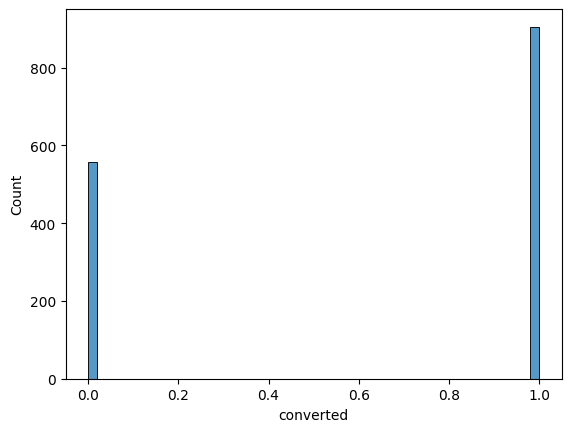

In [7]:
sns.histplot(cls_df[target_col], bins=50)

#### Define functions

In [18]:
# Split the dataset
def split_train_val_test(df, val_ratio=.2, test_ratio=.2, r_seed=1, verbose=False):
    """Use the train_test_split function from sklearn to split input dataframe
    into randomly shuffled train, validation, and test datasets with the
    validation dataset containing val_ratio of the input data and the test
    dataset containing test_ratio of the input data.
    """
    n = len(df)
    # Generate test dataset
    full_train_df, test_df = train_test_split(df, test_size=test_ratio, random_state=r_seed)
    test_df = test_df.reset_index(drop=True)
    # Generate train, validation, and test splits
    val_ft_ratio = val_ratio / (1 - test_ratio)
    train_df, val_df = train_test_split(full_train_df, test_size=val_ft_ratio, random_state=r_seed)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    if verbose:
        print(f"All rows in the original dataframe are contained within the training, validation, or test datasets: {len(train_df) + len(val_df) + len(test_df) == len(df)}")
    return train_df, val_df, test_df

# Prepare X and y
def prepare_X_y(df_list, target_col="converted", verbose=False, labels=[" training "]):
    """Create target vector, y, and feature matrix, X, from input list of
    dataframes, df_list. Use one-hot encoding to transform categorical variables.
    A training dataframe must be input to train the encoder, and it must
    correspond to a label in the input list, labels, that contains the word
    "train". The validation and test dataframes are optional and they will be
    encoded based on a fit to the training dataframe.
    """
    X_list = []
    y_list = []
    for ind, df in enumerate(df_list):
        # print(ind, df)
        df = df.copy()
        y_tmp = df[target_col].values
        tmp_dicts = df.drop(columns=target_col).to_dict(orient="records")
        if "training" in labels[ind]:
            dv = DictVectorizer(sparse=False)
            X_tmp = dv.fit_transform(tmp_dicts)
            X_names = dv.get_feature_names_out()
        else:
            X_tmp = dv.transform(tmp_dicts)
        if verbose:
            if len(labels) != len(df_list):
                labels = labels * len(df_list)
            print(f"All {len(df)} rows in the{labels[ind]}dataframe are contained within X and y: {len(X_tmp) == len(y_tmp) == len(df)}\n")
        X_list.append(X_tmp)
        y_list.append(y_tmp)
    return X_list, y_list, X_names

def evaluate_feature_roc_auc(y, feature_vals):
    return roc_auc_score(y, feature_vals)

def evaluate_classifier(model, X, y, eval_type, threshold=0.5):
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    if eval_type == "accuracy":
        return (y == y_pred).mean()
    elif eval_type == "roc_auc":
        return roc_auc_score(y, y_pred)

def model_logistic_reg_eval_score(X_train, y_train, eval_type, X_val=None, y_val=None, C=1.0, threshold=0.5, verbose=False):
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    # print(model.get_params())
    model.fit(X_train, y_train)
    if isinstance(X_val, np.ndarray):
        if verbose:
            print(f"Returning validation {eval_type} score")
        eval_score = evaluate_classifier(model, X_val, y_val, eval_type, threshold=threshold)
    else:
        if verbose:
            print(f"Returning training {eval_type} score")
        eval_score = evaluate_classifier(model, X_train, y_train, eval_type, threshold=threshold)
    return eval_score


### Split the data into train, validation, and test datasets
1. Split the data in train/val/test sets with 60%/20%/20% distribution
2. Use Scikit-Learn for splitting (the train_test_split function) and set the seed to 42

Make sure that the target value y is not in your dataframe.

In [9]:
train_df, val_df, test_df = split_train_val_test(cls_df, verbose=True)

All rows in the original dataframe are contained within the training, validation, or test datasets: True


### Q1. ROC AUC feature importance
Use ROC AUC to evaluate feature importance of numerical variables
1. For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth
2. Use the training dataset
3. If your AUC is < 0.5, invert feature variable by putting "-" in front (e.g. -df_train['balance'])

Which numerical variable (among the following 4) has the highest AUC?
1. lead_score
2. number_of_courses_viewed
3. interaction_count
4. annual_income

In [10]:
cols_to_score = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
roc_auc_scores = {}
for c in cols_to_score:
    score = evaluate_feature_roc_auc(train_df[target_col].values, train_df[c])
    roc_auc_scores[c] = [score]
roc_auc_by_feat = pd.DataFrame.from_dict(roc_auc_scores, orient='index', columns=['roc_auc'])
roc_auc_by_feat

,roc_auc
lead_score,0.614499
number_of_courses_viewed,0.763568
interaction_count,0.738270
annual_income,0.551958


In [11]:
print(f"The feature with the highest ROC AUC = {BOLD}{roc_auc_by_feat['roc_auc'].idxmax()}")

The feature with the highest ROC AUC = number_of_courses_viewed


### Q2. ROC AUC score on validation dataset
1. Apply one-hot-encoding using DictVectorizer
2. Train the logistic regression with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [12]:
(X_train, X_val), (y_train, y_val), X_names = prepare_X_y([train_df, val_df], verbose=True, labels=[" training ", " validation "])
X_names = X_names.astype(str)

All 876 rows in the training dataframe are contained within X and y: True

All 293 rows in the validation dataframe are contained within X and y: True



In [13]:
X_names

array(['annual_income', 'employment_status=NA',
       'employment_status=employed', 'employment_status=self_employed',
       'employment_status=student', 'employment_status=unemployed',
       'industry=NA', 'industry=education', 'industry=finance',
       'industry=healthcare', 'industry=manufacturing', 'industry=other',
       'industry=retail', 'industry=technology', 'interaction_count',
       'lead_score', 'lead_source=NA', 'lead_source=events',
       'lead_source=organic_search', 'lead_source=paid_ads',
       'lead_source=referral', 'lead_source=social_media', 'location=NA',
       'location=africa', 'location=asia', 'location=australia',
       'location=europe', 'location=middle_east',
       'location=north_america', 'location=south_america',
       'number_of_courses_viewed'], dtype='<U31')

In [19]:
ra_score = model_logistic_reg_eval_score(X_train, y_train, "roc_auc", X_val=X_val, y_val=y_val, verbose=True)
ra_score

Returning validation roc_auc score


0.647564950627936

In [15]:
print(f"The ROC AUC score for the validation dataset = {BOLD}{round(ra_score, 3)}")

The ROC AUC score for the validation dataset = 0.648


### Q3. Precision and Recall
Now let's compute precision and recall for our model.
1. Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
2. For each threshold, compute precision and recall and plot them

At which threshold precision and recall curves intersect?

In [ ]:
print(f" {BOLD}{None}")

### Q4. Logistic regression model accuracy
Train a logistic regression model
1. Include categorical variables using one-hot encoding
2. Fit the model on the training dataset
3. Use Scikit-Learn to fit the model with these parameters:
    - model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
4. Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?

In [ ]:
(X_train, X_val), (y_train, y_val), X_names = prepare_X_y([train_df, val_df], verbose=True, labels=[" training ", " validation "])
X_names = X_names.astype(str)

In [ ]:
accuracy = model_logistic_reg_accuracy(X_train, y_train, X_val=X_val)
accuracy

In [ ]:
print(f"Logistic regression model accuracy = {BOLD}{round(accuracy, 2)}")

### Q5. Effect of different random seeds for splitting into train/validation/test datasets
Find the least useful feature using the feature elimination technique.
1. Train a model using the same features and parameters as in Q4 (without rounding)
2. Exclude each feature from this set and train a model without it
3. Record the accuracy for each model
4. For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

Which of the following features has the smallest difference?
- 'industry'
- 'employment_status'
- 'lead_score'

Note: The difference doesn't have to be positive.

In [ ]:
train_accuracy = model_logistic_reg_accuracy(X_train, y_train)
print(f"Overall training accuracy = {train_accuracy}")
cols_to_test = ['industry', 'employment_status', 'lead_score']
train_ctt_accuracy = {}
for ctt in cols_to_test:
    ctt_acc_df = {}
    X_train_rc = remove_col_from_X(X_train, X_names, ctt)
    ctt_acc = model_logistic_reg_accuracy(X_train_rc, y_train)
    train_ctt_accuracy[ctt] = [ctt_acc, abs(ctt_acc-train_accuracy)]
acc_by_missing_col = pd.DataFrame.from_dict(train_ctt_accuracy, orient='index', columns=['accuracy', 'accuracy_diff'])
acc_by_missing_col

In [ ]:
print(f"The column that has the smallest absolute change on accuracy = {BOLD}{acc_by_missing_col['accuracy_diff'].idxmin()}")

### Q6. C with best validation accuracy
Train a regularized logistic regression.
1. Try the following values of the parameter C: [0.01, 0.1, 1, 10, 100]
2. Train models using all the features as in Q4
3. Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

Which of these C leads to the best accuracy on the validation set?

In [ ]:
C_test = [0.01, 0.1, 1., 10., 100.]
val_c_acc = []
for C in C_test:
    vc_acc = model_logistic_reg_accuracy(X_train, y_train, X_val=X_val, C=C, verbose=True)
    print(C, vc_acc)
    val_c_acc.append(round(vc_acc, 3))

In [ ]:
print(f"The smallest C value with the highest accuracy = {BOLD}{C_test[val_c_acc.index(max(val_c_acc))]}")

### Extra Credit

In [ ]:
# Decreasing C by another order of magnitude causes a sudden drop in accuracy
C = 0.001
vc_acc = model_logistic_reg_accuracy(X_train, y_train, X_val=X_val, C=C, verbose=True)
print(C, vc_acc)